In [12]:
from envs.KS_solver_jax import KS
from envs.KS_environment_jax import KSenv
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt

In [124]:
actuator_locs =  ((2 * jnp.pi) / 8) * jnp.arange(8)
actuator_scale = 0.1
nu = 0.02
N = 64
dt = 0.05
my_KS = KS(actuator_locs=actuator_locs,
       actuator_scale=actuator_scale, 
       nu=nu, 
       N=N, 
       dt=dt)

In [125]:
null_action = jnp.zeros(my_KS.B.shape[1])

# initial condition
burn_in = 1000
key = jax.random.PRNGKey(seed=0)
key1, key2 = jax.random.split(key)

u0_1,_,_ = KSenv.reset(N=my_KS.N, 
                    B=my_KS.B, 
                    lin=my_KS.lin, 
                    ik=my_KS.ik, 
                    dt=my_KS.dt, 
                    initial_amplitude=1e-2,
                    action_size=my_KS.B.shape[1],
                    burn_in=burn_in,
                    observation_inds=jnp.arange(0, N, 1),
                    key=key1)

u0_2,_,_ = KSenv.reset(N=my_KS.N, 
                    B=my_KS.B, 
                    lin=my_KS.lin, 
                    ik=my_KS.ik, 
                    dt=my_KS.dt, 
                    initial_amplitude=1e-2,
                    action_size=my_KS.B.shape[1],
                    burn_in=burn_in,
                    observation_inds=jnp.arange(0, N, 1),
                    key=key2)

In [146]:
# Observations
n_sensors = 16
sensor_locs = ((2 * jnp.pi) / n_sensors) * jnp.arange(n_sensors)
observation_inds = [
    int(jnp.round(x)) for x in (N / (2 * jnp.pi)) * sensor_locs
]
observation_inds = jnp.array(observation_inds)

In [149]:
def step_fn(carry, _):
    u1, u2 = carry
    u1 = KS.advance(u0=u1, action=null_action, B=my_KS.B, lin=my_KS.lin, ik=my_KS.ik, dt=my_KS.dt)
    u2 = u2.at[observation_inds].set(u1[observation_inds])
    u2 = KS.advance(u0=u2, action=null_action, B=my_KS.B, lin=my_KS.lin, ik=my_KS.ik, dt=my_KS.dt)
    return (u1, u2), (u1, u2)

sim_length = 100
(u1_final, u2_final), (u1, u2) = jax.lax.scan(step_fn, (u0_1, u0_2), xs=None, length=sim_length)

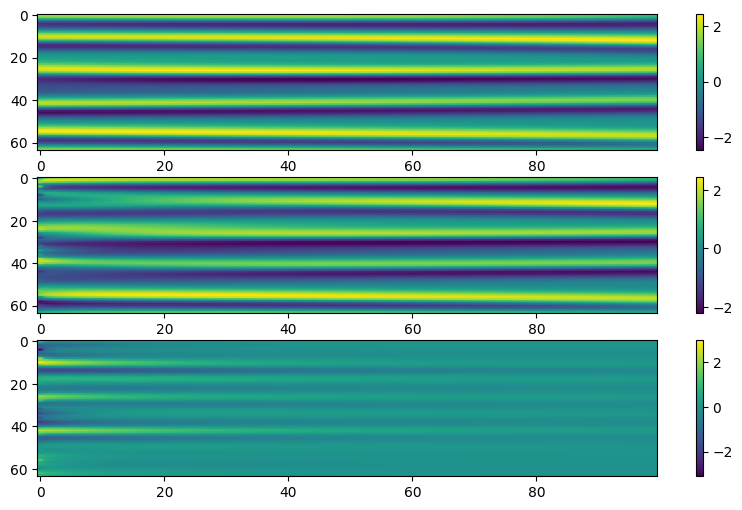

In [150]:
plt.figure(figsize=(10,6))
plt.subplot(3, 1, 1)
plt.imshow(u1.T, aspect='auto')
plt.colorbar()
plt.subplot(3, 1, 2)
plt.imshow(u2.T, aspect='auto')
plt.colorbar()
plt.subplot(3, 1, 3)
plt.imshow(u1.T-u2.T, aspect='auto')
plt.colorbar()